# Imputacion de Datos Faltantes para la Precipitacion del Meta mediante modelacion RF

Este Jupyter Notebook se enfoca en el desarrolo metodologico del trabajo de grado de los estudiantes Ronaldo Hernandez Mejia y Hector Freddy Velasco, en el cual se enfoca en la imputaciopn de datos faltnates para la variable de precipitacion en el departamento del Meta, Colombia. Con una gran volumen de datos de la informacion diaria de la precipitacion desde 1980 hasta el 2016, seleccionando un total de 56 Estaciones meteorologias del IDEAM.

La región del Meta es muy importante en este país por la diversidad del clima y su efecto sobre la agricultura y otros sectores económicos. La variabilidad de las precipitaciones juega un papel importante en el análisis del clima y la toma de decisiones relacionadas con  la gestión del agua y el clima. 

El objetivo principal es desarrolar un modelo basado en el algotimo K-Nearest Neighbors(KNN) para imputar los datos faltantes de precipitacion, utilizando un conjunto de datos que contiene mas de 700.000 observaciones. 

Dada la gran cantidad de datos se ha implementado una version que utiliza los cores del procesador para ejecutar el modelo en paralelo optimizando asi el tiempo de ejecucion, mejorando la eficiencia computacional y acelerar el proceso, tambien por este motivo el desarrolo en python tiene tiempos de respuesta cortos en el manejo de datos.



### instalacion de librerias

In [1]:
import subprocess
import sys
import importlib

def install_and_import(package):
    try:
        importlib.import_module(package)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
    finally:
        globals()[package] = importlib.import_module(package)


In [2]:
packages = ['pandas', 'IPython', 'pandasgui', 'numpy', 'matplotlib','joblib','sklearn']

for package in packages:
    install_and_import(package)


En caso de que no funcione instalacion manual:

In [3]:
import os
#observar donde estoy en ruta 
os.getcwd()

'c:\\Users\\vhect\\Desktop\\tesis codigos'

ruta ronaldo 

In [ ]:
# import os
# current_path = os.getcwd()
# print(f"Ruta actual del directorio de trabajo: {current_path}")
# new_path = "F:\\TESIS\\Proyecto_mod_precipitacion"
# os.chdir(new_path)
# new_current_path = os.getcwd()
# print(f"Nueva ruta del directorio de trabajo: {new_current_path}")

ruta hector 


In [4]:
import os
current_path = os.getcwd()
print(f"Ruta actual del directorio de trabajo: {current_path}")
new_path = "c:\\Users\\vhect\\Documents\\semestre 10\\TESIS\\Proyecto_mod_precipitacion"
os.chdir(new_path)
new_current_path = os.getcwd()
print(f"Nueva ruta del directorio de trabajo: {new_current_path}")

Ruta actual del directorio de trabajo: c:\Users\vhect\Desktop\tesis codigos
Nueva ruta del directorio de trabajo: c:\Users\vhect\Documents\semestre 10\TESIS\Proyecto_mod_precipitacion


### Lectura de datos

In [5]:
import pandas as pd

In [6]:
data = pd.read_csv("Datos/datos_seleccionados_para_modelo_coordenadas.txt",sep=";")
data.head()

,Date,prec,ID,LAT,LON
0,1983-06-09,6.8,32010010,2.562833,-74.103083
1,1983-06-10,17.8,32010010,2.562833,-74.103083
2,1983-06-11,0.0,32010010,2.562833,-74.103083
3,1983-06-12,0.5,32010010,2.562833,-74.103083
4,1983-06-13,6.9,32010010,2.562833,-74.103083


Estructura de los datos

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 656436 entries, 0 to 656435
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Date    656436 non-null  object 
 1   prec    592124 non-null  float64
 2   ID      656436 non-null  int64  
 3   LAT     656436 non-null  float64
 4   LON     656436 non-null  float64
dtypes: float64(3), int64(1), object(1)
memory usage: 25.0+ MB


Visualizacion de los datos faltantes 

<Figure size 1000x600 with 0 Axes>

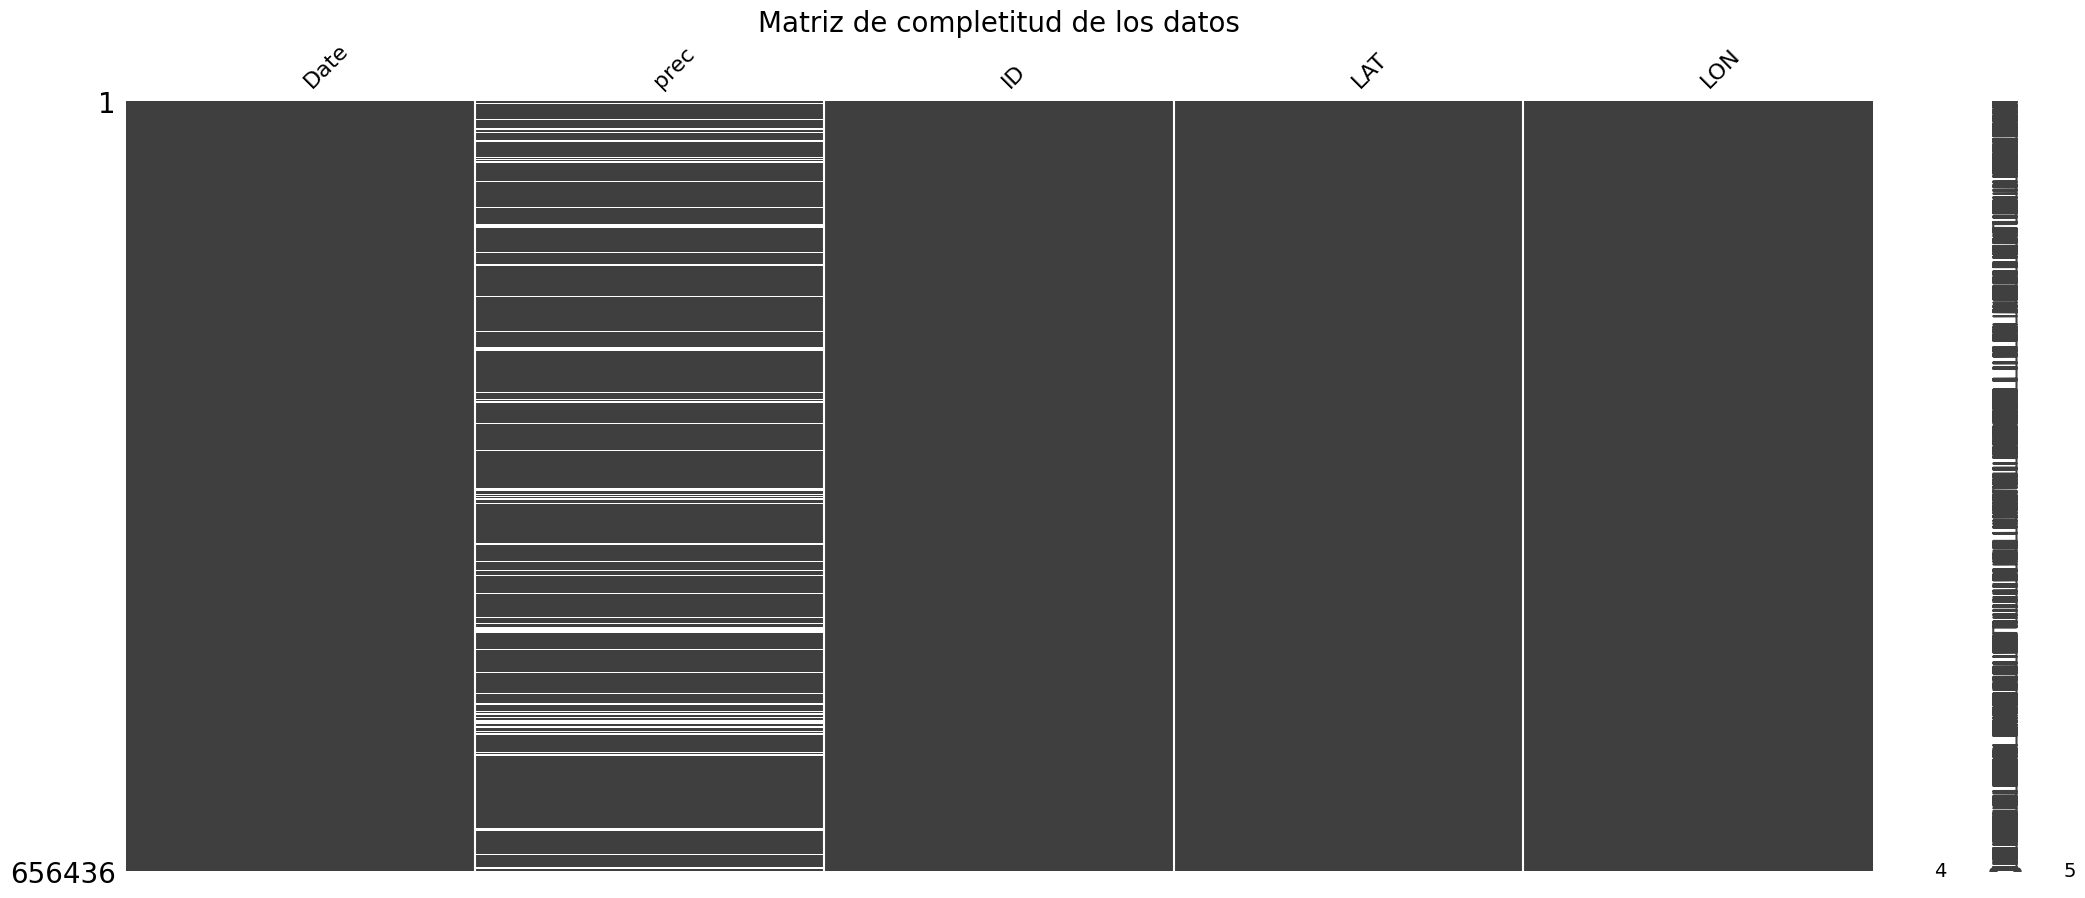

<Figure size 1000x600 with 0 Axes>

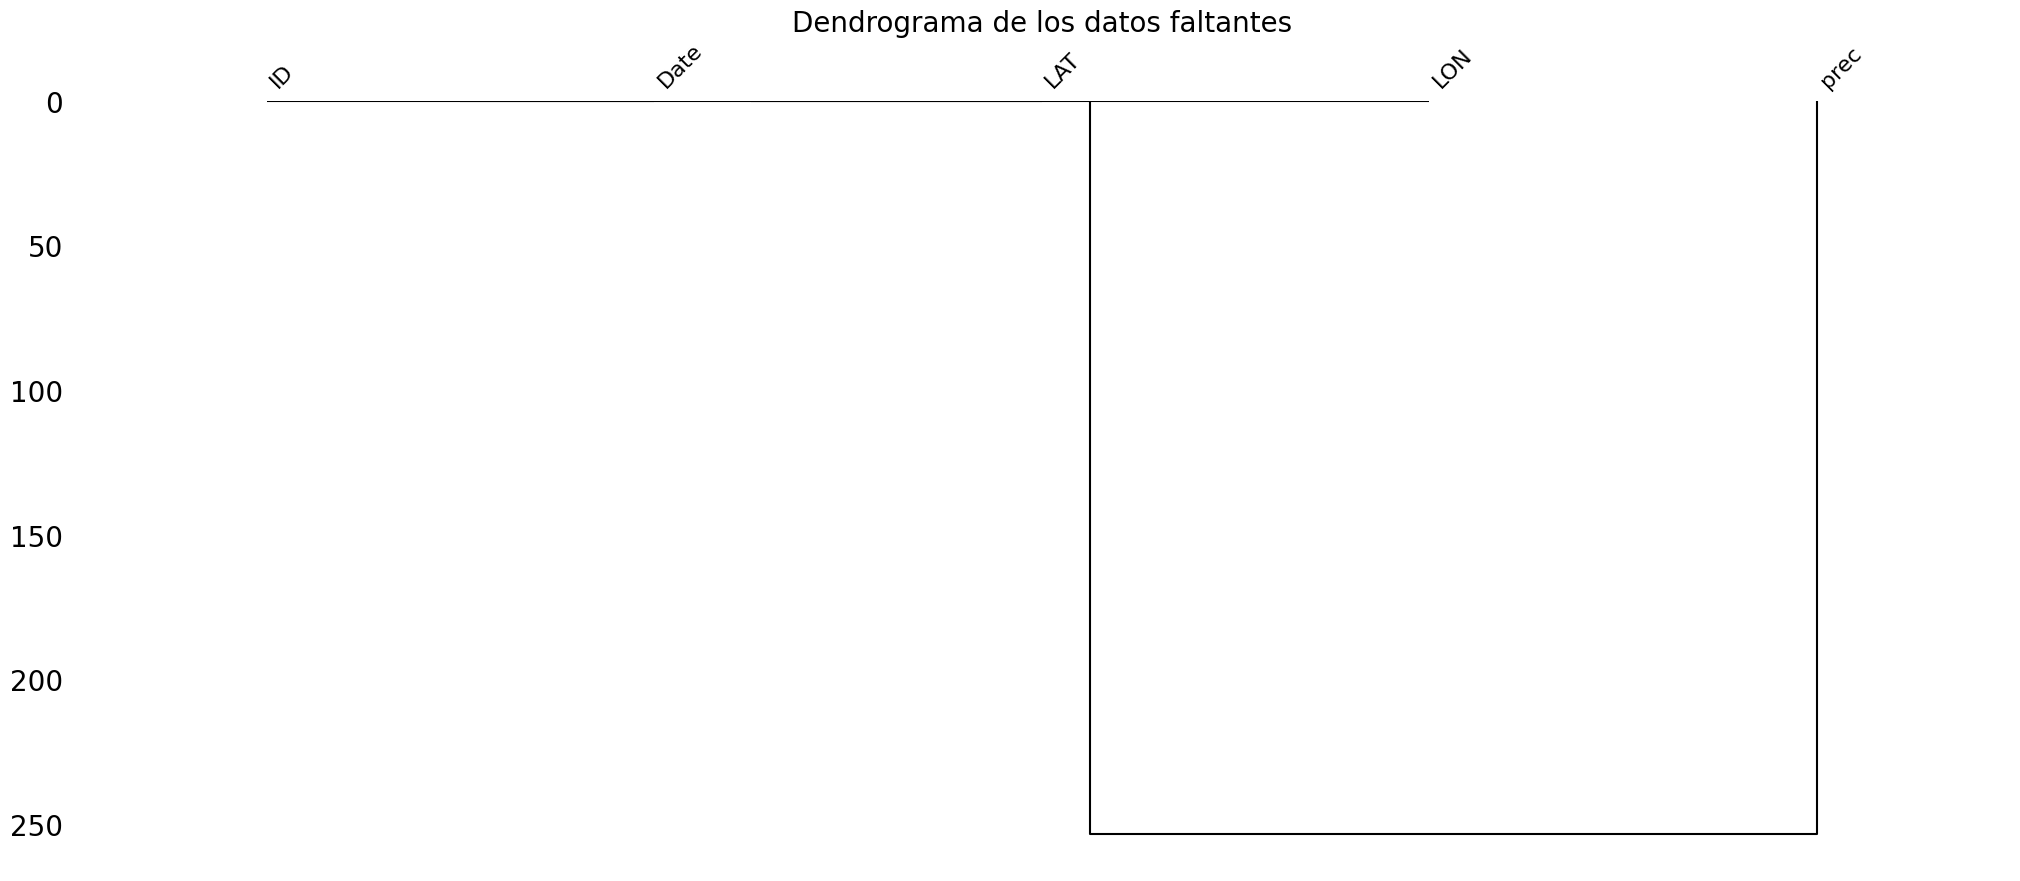

Date        0
prec    64312
ID          0
LAT         0
LON         0
dtype: int64


In [8]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt

# Suponemos que 'data' es tu DataFrame

# Visualizar la completitud de los datos con matriz
plt.figure(figsize=(10,6))
msno.matrix(data)
plt.title('Matriz de completitud de los datos', fontsize=20)
plt.show()

# Agrupar las columnas con datos faltantes similares con dendrograma
plt.figure(figsize=(10,6))
msno.dendrogram(data)
plt.title('Dendrograma de los datos faltantes', fontsize=20)
plt.show()

# Resumen de la cantidad de datos faltantes por columna
print(data.isnull().sum())


### Correccion de variables para el modelo

In [9]:
data.head(5)

,Date,prec,ID,LAT,LON
0,1983-06-09,6.8,32010010,2.562833,-74.103083
1,1983-06-10,17.8,32010010,2.562833,-74.103083
2,1983-06-11,0.0,32010010,2.562833,-74.103083
3,1983-06-12,0.5,32010010,2.562833,-74.103083
4,1983-06-13,6.9,32010010,2.562833,-74.103083


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 656436 entries, 0 to 656435
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Date    656436 non-null  object 
 1   prec    592124 non-null  float64
 2   ID      656436 non-null  int64  
 3   LAT     656436 non-null  float64
 4   LON     656436 non-null  float64
dtypes: float64(3), int64(1), object(1)
memory usage: 25.0+ MB


In [11]:
# Asegurarte de que 'Date' es una columna datetime
data['Date'] = pd.to_datetime(data['Date'])

# Crear nuevas columnas para el año, mes y día
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day

# Crear un nuevo dataframe con las columnas deseadas
new_data = data[['ID', 'Year', 'Month', 'Day', 'prec', 'LAT', 'LON']].copy()


In [12]:
new_data = new_data.sort_values('ID')


In [13]:
new_data.head(10)

,ID,Year,Month,Day,prec,LAT,LON
0,32010010,1983,6,9,6.8,2.562833,-74.103083
8045,32010010,2005,6,18,8.0,2.562833,-74.103083
8046,32010010,2005,6,19,12.0,2.562833,-74.103083
8047,32010010,2005,6,20,0.0,2.562833,-74.103083
8048,32010010,2005,6,21,4.0,2.562833,-74.103083
8049,32010010,2005,6,22,0.0,2.562833,-74.103083
8050,32010010,2005,6,23,3.0,2.562833,-74.103083
8051,32010010,2005,6,24,41.0,2.562833,-74.103083
8052,32010010,2005,6,25,8.0,2.562833,-74.103083
8053,32010010,2005,6,26,3.0,2.562833,-74.103083


In [14]:
new_data = new_data.rename(columns={
    'Year': 'Año',
    'Month': 'Mes',
    'Day': 'Día',
    'prec': 'prec',
    'LAT': 'LAT',
    'LON': 'LON'
})


In [15]:
new_data = new_data[['Año', 'Mes', 'Día', 'prec', 'LAT', 'LON']]


In [16]:
new_data.head(5)

,Año,Mes,Día,prec,LAT,LON
0,1983,6,9,6.8,2.562833,-74.103083
8045,2005,6,18,8.0,2.562833,-74.103083
8046,2005,6,19,12.0,2.562833,-74.103083
8047,2005,6,20,0.0,2.562833,-74.103083
8048,2005,6,21,4.0,2.562833,-74.103083


In [17]:
data = pd.read_csv("Datos/datos_seleccionados_para_modelo_coordenadas.txt",sep=";")
data.head()

,Date,prec,ID,LAT,LON
0,1983-06-09,6.8,32010010,2.562833,-74.103083
1,1983-06-10,17.8,32010010,2.562833,-74.103083
2,1983-06-11,0.0,32010010,2.562833,-74.103083
3,1983-06-12,0.5,32010010,2.562833,-74.103083
4,1983-06-13,6.9,32010010,2.562833,-74.103083


<Figure size 1000x600 with 0 Axes>

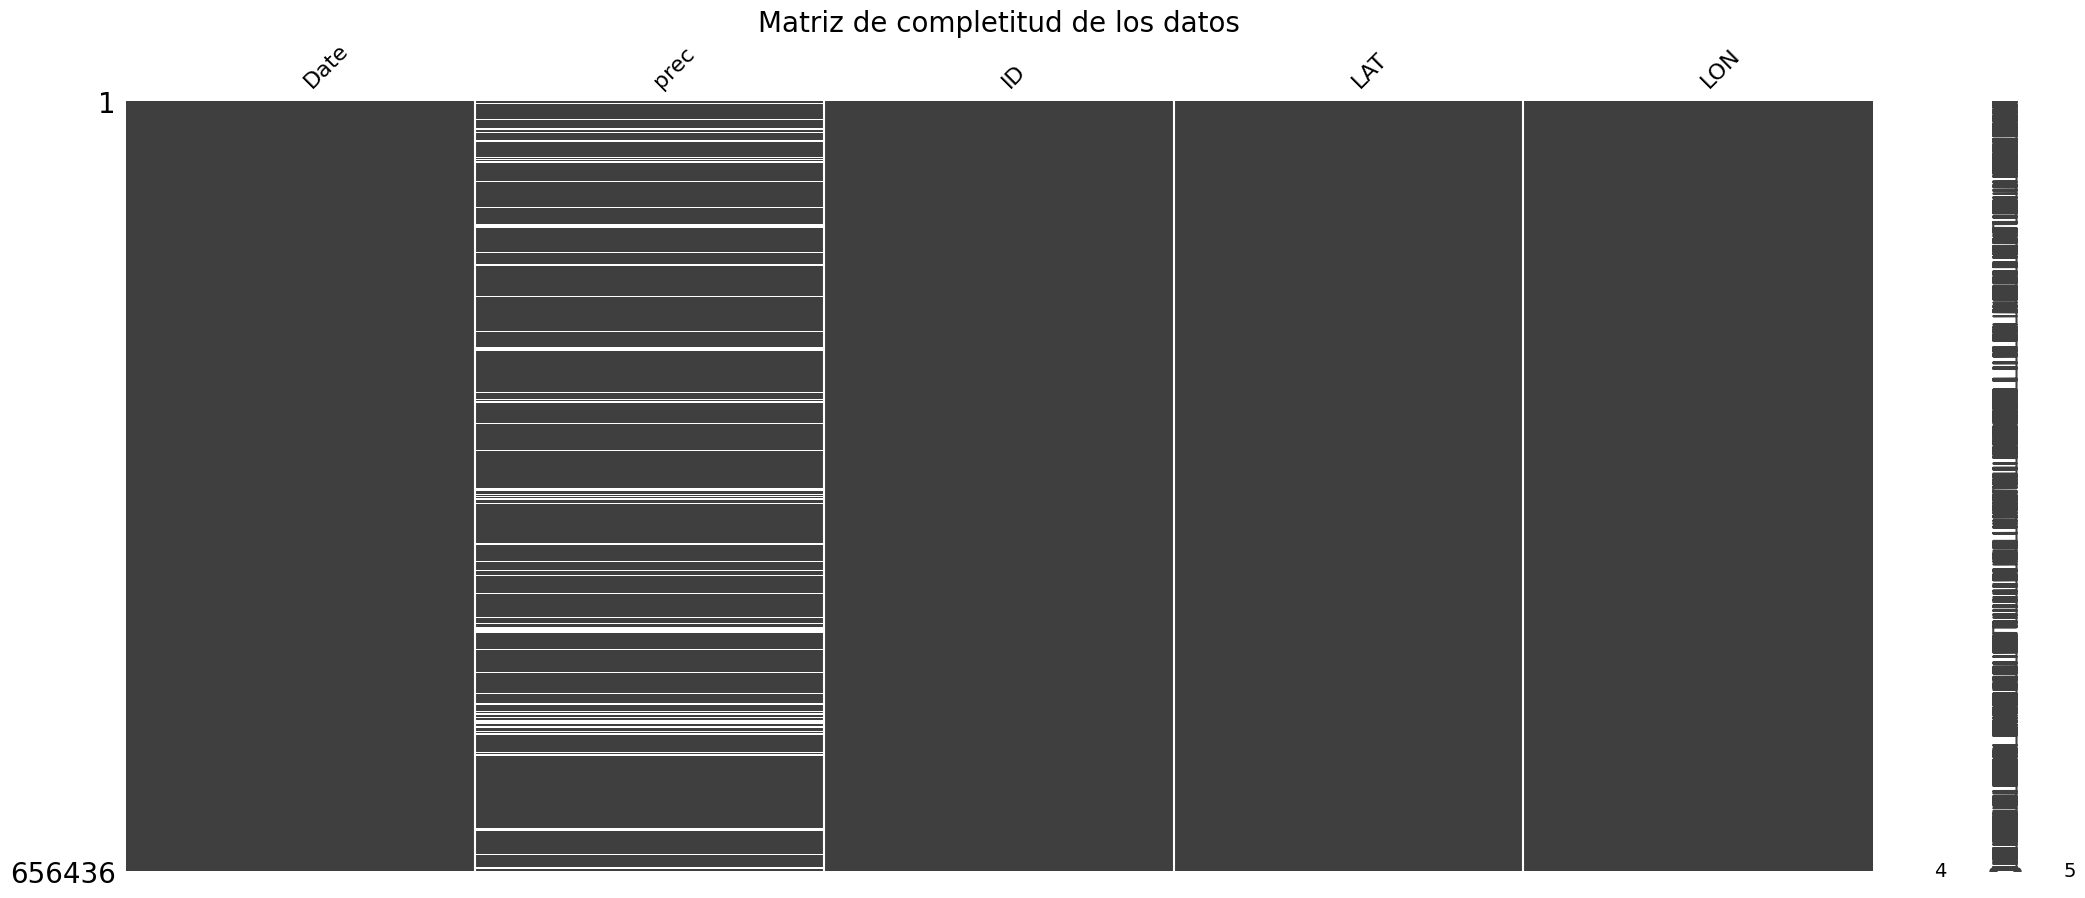

In [18]:
import missingno as msno
import matplotlib.pyplot as plt

# Suponemos que 'data' es tu DataFrame

# Visualizar la completitud de los datos con matriz
plt.figure(figsize=(10,6))
msno.matrix(data)
plt.title('Matriz de completitud de los datos', fontsize=20)
plt.show()

In [40]:
# Calcula la cantidad de datos faltantes por columna en data
missing_data = data.isnull().sum()

# Imprime la cantidad de datos faltantes por columna
print(missing_data)


Date        0
prec    64312
ID          0
LAT         0
LON         0
dtype: int64


In [19]:
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data = data.drop('Date', axis=1)


In [20]:
data

,prec,ID,LAT,LON,Year,Month,Day
0,6.8,32010010,2.562833,-74.103083,1983,6,9
1,17.8,32010010,2.562833,-74.103083,1983,6,10
2,0.0,32010010,2.562833,-74.103083,1983,6,11
3,0.5,32010010,2.562833,-74.103083,1983,6,12
4,6.9,32010010,2.562833,-74.103083,1983,6,13
...,...,...,...,...,...,...,...
656431,0.1,35185010,4.260361,-72.564472,2014,7,14
656432,9.8,35185010,4.260361,-72.564472,2014,7,15
656433,0.0,35185010,4.260361,-72.564472,2014,7,16
656434,4.5,35185010,4.260361,-72.564472,2014,7,17


## Random Forest

In [21]:
## Randiom forest
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from joblib import Parallel, delayed



# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(data.drop('prec', axis=1), data['prec'], test_size=0.3, random_state=42)
# Seleccionar solo las columnas numéricas para la imputación
imputer = SimpleImputer(strategy='mean')
numeric_columns = X_train.select_dtypes(include=[np.number])
X_train_imputed = imputer.fit_transform(numeric_columns)
X_test_imputed = imputer.transform(X_test[numeric_columns.columns])



# Crea un modelo Random Forest para la imputación
rf_imputer = RandomForestRegressor(n_estimators=100, random_state=42)

# Define una función para entrenar y predecir en paralelo
def train_and_predict_rf(X_train, y_train, X_test_imputed):
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    return rf.predict(X_test_imputed)

# Elimina filas con valores faltantes en X_train_imputed e y_train
X_train_imputed, y_train = X_train_imputed[~np.isnan(y_train)], y_train[~np.isnan(y_train)]
# # Entrena y predice en paralelo para el conjunto de prueba
X_test_imputed_with_rf = Parallel(n_jobs=4)(delayed(train_and_predict_rf)(X_train_imputed, y_train, X_test_imputed) for _ in range(5))  # Puedes ajustar el número de repeticiones según sea necesario


In [22]:
mask = ~np.isnan(y_test)
y_test = y_test[mask]
X_test_imputed_with_rf = [x[mask] for x in X_test_imputed_with_rf]


In [23]:
# Calcula el MSE para evaluar el rendimiento
mse_rf = mean_squared_error(y_test, np.mean(X_test_imputed_with_rf, axis=0))

print(f"MSE de Random Forest para imputación: {mse_rf}")

MSE de Random Forest para imputación: 288.9237350040928


## Bibliografia 

Little, R. J. A., & Rubin, D. B. (2002). Statistical Analysis with Missing Data (Vol. 333). John Wiley & Sons.